In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [2]:
df = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_test.csv')
df = df[(df['label'] ==5) | (df['label'] ==6) | (df['label'] ==7) | (df['label'] ==0) | (df['label'] ==2)]

In [3]:
df['label'].value_counts()

label
2    1032
7    1028
0     980
6     958
5     892
Name: count, dtype: int64

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [5]:
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.data = df[(df['label'] ==5) | (df['label'] ==6) | (df['label'] ==7) | (df['label'] ==0) | (df['label'] ==2)]
        self.X = self.data.iloc[:, :-1].values
        label_map = {0: 0, 2: 1, 5: 2, 6: 3, 7: 4}
        self.y = self.data['label'].map(label_map).values
        #self.y = self.data.iloc[:, -1].values
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [6]:
train_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_test.csv')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
activation_functions = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "swish": nn.SiLU
}

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation_name):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.activation = activation_functions[activation_name.lower()]()
            
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        #x = F.softmax(x, dim=1)
        return x

def train_model(model, optimizer, criterion, epochs=50):
    criterion = nn.CrossEntropyLoss()
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss+=loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_test_loss +=loss.item()
    
                _, predicted = torch.max(outputs.data, 1)
                correct_test+=(predicted==labels).sum().item()
                total_test +=labels.size(0)
            
        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
    
        print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}% | "
                  f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy*100:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies



In [10]:
model = NeuralNetwork(28*28, 128, 64, 5, 'relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [11]:
train_losses_relu, test_losses_relu, train_acc_relu, test_acc_relu = train_model(model, optimizer, criterion, epochs=50)

Epoch 1/50 | Train Loss: 1.2321, Train Acc: 74.51% | Test Loss: 0.3618, Test Acc: 90.06%
Epoch 2/50 | Train Loss: 0.2767, Train Acc: 92.16% | Test Loss: 0.2383, Test Acc: 93.15%
Epoch 3/50 | Train Loss: 0.1847, Train Acc: 94.74% | Test Loss: 0.1857, Test Acc: 94.74%
Epoch 4/50 | Train Loss: 0.1386, Train Acc: 95.98% | Test Loss: 0.1590, Test Acc: 95.54%
Epoch 5/50 | Train Loss: 0.1085, Train Acc: 96.78% | Test Loss: 0.1363, Test Acc: 96.03%
Epoch 6/50 | Train Loss: 0.0877, Train Acc: 97.35% | Test Loss: 0.1249, Test Acc: 96.22%
Epoch 7/50 | Train Loss: 0.0712, Train Acc: 97.81% | Test Loss: 0.1135, Test Acc: 96.63%
Epoch 8/50 | Train Loss: 0.0581, Train Acc: 98.29% | Test Loss: 0.1077, Test Acc: 96.83%
Epoch 9/50 | Train Loss: 0.0478, Train Acc: 98.59% | Test Loss: 0.1003, Test Acc: 97.08%
Epoch 10/50 | Train Loss: 0.0398, Train Acc: 98.83% | Test Loss: 0.0966, Test Acc: 97.14%
Epoch 11/50 | Train Loss: 0.0332, Train Acc: 99.04% | Test Loss: 0.0931, Test Acc: 97.30%
Epoch 12/50 | Train

In [12]:
model2 = NeuralNetwork(28*28, 128, 64, 5, 'sigmoid').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.00001)

In [13]:
train_losses_sigmoid, test_losses_sigmoid, train_acc_sigmoid, test_acc_sigmoid = train_model(model2, optimizer, criterion, epochs=50)

Epoch 1/50 | Train Loss: 1.5261, Train Acc: 32.82% | Test Loss: 1.4274, Test Acc: 64.01%
Epoch 2/50 | Train Loss: 1.3422, Train Acc: 74.94% | Test Loss: 1.2551, Test Acc: 82.82%
Epoch 3/50 | Train Loss: 1.1811, Train Acc: 84.89% | Test Loss: 1.1040, Test Acc: 87.16%
Epoch 4/50 | Train Loss: 1.0355, Train Acc: 88.57% | Test Loss: 0.9644, Test Acc: 90.20%
Epoch 5/50 | Train Loss: 0.9018, Train Acc: 90.96% | Test Loss: 0.8378, Test Acc: 91.98%
Epoch 6/50 | Train Loss: 0.7813, Train Acc: 92.59% | Test Loss: 0.7250, Test Acc: 92.92%
Epoch 7/50 | Train Loss: 0.6743, Train Acc: 93.52% | Test Loss: 0.6260, Test Acc: 93.44%
Epoch 8/50 | Train Loss: 0.5803, Train Acc: 94.12% | Test Loss: 0.5399, Test Acc: 94.01%
Epoch 9/50 | Train Loss: 0.4996, Train Acc: 94.59% | Test Loss: 0.4672, Test Acc: 94.36%
Epoch 10/50 | Train Loss: 0.4319, Train Acc: 94.91% | Test Loss: 0.4069, Test Acc: 94.40%
Epoch 11/50 | Train Loss: 0.3751, Train Acc: 95.19% | Test Loss: 0.3566, Test Acc: 94.64%
Epoch 12/50 | Train

In [14]:
model3 = NeuralNetwork(28*28, 128, 64, 5, 'tanh').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.00001)

In [15]:
train_losses_tanh, test_losses_tanh, train_acc_tanh, test_acc_tanh = train_model(model3, optimizer, criterion, epochs=50)

Epoch 1/50 | Train Loss: 1.2708, Train Acc: 63.63% | Test Loss: 0.9435, Test Acc: 85.34%
Epoch 2/50 | Train Loss: 0.7445, Train Acc: 88.62% | Test Loss: 0.5802, Test Acc: 91.08%
Epoch 3/50 | Train Loss: 0.4847, Train Acc: 91.79% | Test Loss: 0.4024, Test Acc: 92.78%
Epoch 4/50 | Train Loss: 0.3499, Train Acc: 93.15% | Test Loss: 0.3085, Test Acc: 93.37%
Epoch 5/50 | Train Loss: 0.2735, Train Acc: 94.00% | Test Loss: 0.2533, Test Acc: 94.05%
Epoch 6/50 | Train Loss: 0.2255, Train Acc: 94.70% | Test Loss: 0.2197, Test Acc: 94.44%
Epoch 7/50 | Train Loss: 0.1929, Train Acc: 95.25% | Test Loss: 0.1958, Test Acc: 94.76%
Epoch 8/50 | Train Loss: 0.1698, Train Acc: 95.61% | Test Loss: 0.1803, Test Acc: 95.07%
Epoch 9/50 | Train Loss: 0.1528, Train Acc: 95.89% | Test Loss: 0.1687, Test Acc: 95.42%
Epoch 10/50 | Train Loss: 0.1390, Train Acc: 96.19% | Test Loss: 0.1597, Test Acc: 95.46%
Epoch 11/50 | Train Loss: 0.1282, Train Acc: 96.43% | Test Loss: 0.1526, Test Acc: 95.56%
Epoch 12/50 | Train

In [16]:
model4 = NeuralNetwork(28*28, 128, 64, 5, 'swish').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.00001)

In [17]:
train_losses_swish, test_losses_swish, train_acc_swish, test_acc_swish = train_model(model4, optimizer, criterion, epochs=50)

Epoch 1/50 | Train Loss: 1.1383, Train Acc: 73.79% | Test Loss: 0.3705, Test Acc: 89.59%
Epoch 2/50 | Train Loss: 0.2887, Train Acc: 91.86% | Test Loss: 0.2303, Test Acc: 93.37%
Epoch 3/50 | Train Loss: 0.1893, Train Acc: 94.60% | Test Loss: 0.1762, Test Acc: 94.95%
Epoch 4/50 | Train Loss: 0.1410, Train Acc: 95.88% | Test Loss: 0.1435, Test Acc: 95.89%
Epoch 5/50 | Train Loss: 0.1099, Train Acc: 96.73% | Test Loss: 0.1250, Test Acc: 96.38%
Epoch 6/50 | Train Loss: 0.0882, Train Acc: 97.38% | Test Loss: 0.1141, Test Acc: 96.79%
Epoch 7/50 | Train Loss: 0.0715, Train Acc: 97.90% | Test Loss: 0.1051, Test Acc: 96.97%
Epoch 8/50 | Train Loss: 0.0590, Train Acc: 98.21% | Test Loss: 0.0958, Test Acc: 97.30%
Epoch 9/50 | Train Loss: 0.0490, Train Acc: 98.55% | Test Loss: 0.0903, Test Acc: 97.36%
Epoch 10/50 | Train Loss: 0.0407, Train Acc: 98.81% | Test Loss: 0.0851, Test Acc: 97.59%
Epoch 11/50 | Train Loss: 0.0342, Train Acc: 99.04% | Test Loss: 0.0833, Test Acc: 97.71%
Epoch 12/50 | Train

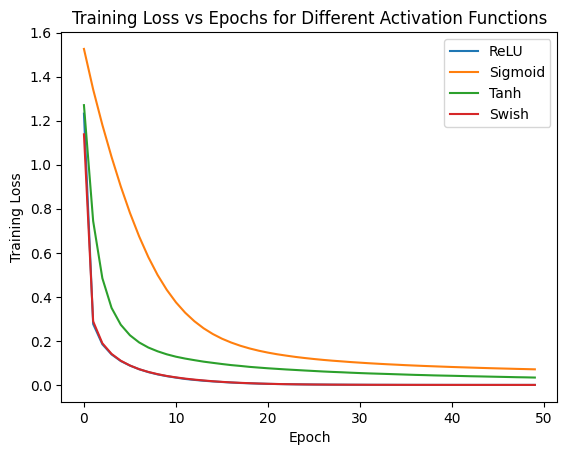

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_losses_relu, label='ReLU')
plt.plot(train_losses_sigmoid, label='Sigmoid')
plt.plot(train_losses_tanh, label='Tanh')
plt.plot(train_losses_swish, label='Swish')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs for Different Activation Functions")
plt.legend()
plt.show()


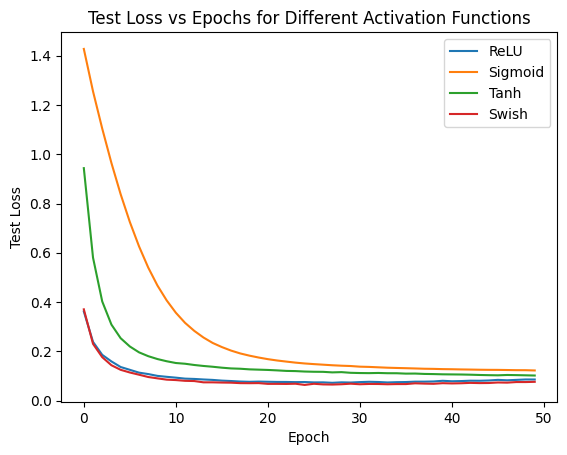

In [19]:
plt.plot(test_losses_relu, label='ReLU')
plt.plot(test_losses_sigmoid, label='Sigmoid')
plt.plot(test_losses_tanh, label='Tanh')
plt.plot(test_losses_swish, label='Swish')
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss vs Epochs for Different Activation Functions")
plt.legend()
plt.show()


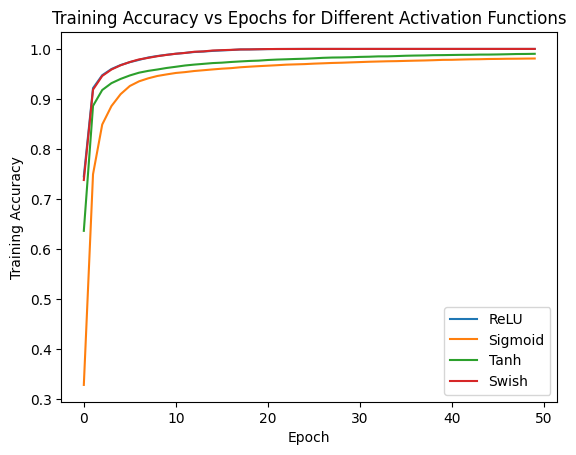

In [20]:
plt.plot(train_acc_relu, label='ReLU')
plt.plot(train_acc_sigmoid, label='Sigmoid')
plt.plot(train_acc_tanh, label='Tanh')
plt.plot(train_acc_swish, label='Swish')
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Epochs for Different Activation Functions")
plt.legend()
plt.show()


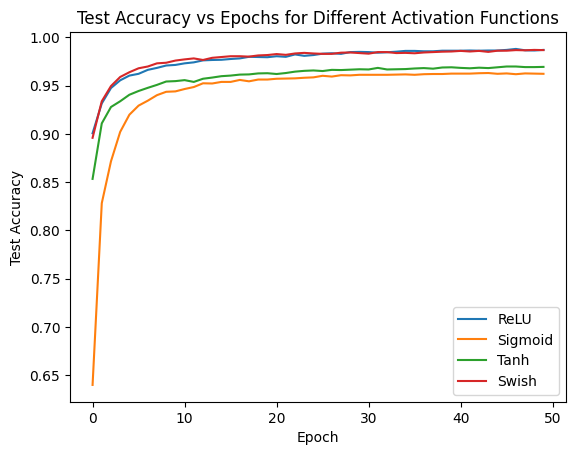

In [21]:
plt.plot(test_acc_relu, label='ReLU')
plt.plot(test_acc_sigmoid, label='Sigmoid')
plt.plot(test_acc_tanh, label='Tanh')
plt.plot(test_acc_swish, label='Swish')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Epochs for Different Activation Functions")
plt.legend()
plt.show()
